# Sectin 1: Intro
- Build a diffusion model capable to sample new images from bitmoji dataset
- Dataset path can be found here: https://www.kaggle.com/datasets/mostafamozafari/bitmoji-faces 

# Section 2: Install required packages and upload data  

In [1]:
!pip3 install --upgrade pip
!pip3 install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00


In [2]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser
import shutil
from pathlib import Path
import os
import cv2 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
import torchvision.transforms as transforms

# Setting reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
store_path = f"ddpm_model_mnist.pt"

In [4]:
!unzip '/content/drive/MyDrive/bitmoji_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: bitmojis/199991388-10212369-0.png  
  inflating: bitmojis/199991389-10212369-0.png  
  inflating: bitmojis/199991390-10212369-0.png  
  inflating: bitmojis/199991391-10212369-0.png  
  inflating: bitmojis/199991392-10212369-0.png  
  inflating: bitmojis/199991394-10212369-0.png  
  inflating: bitmojis/199991395-10212369-0.png  
  inflating: bitmojis/199991398-10212369-0.png  
  inflating: bitmojis/199991400-10212369-0.png  
  inflating: bitmojis/199991401-10212369-0.png  
  inflating: bitmojis/199991403-10212369-0.png  
  inflating: bitmojis/199991404-10212369-0.png  
  inflating: bitmojis/199991405-10212369-0.png  
  inflating: bitmojis/199991407-10212369-0.png  
  inflating: bitmojis/199991409-10212369-0.png  
  inflating: bitmojis/199991410-10212369-0.png  
  inflating: bitmojis/199991411-10212369-0.png  
  inflating: bitmojis/199991412-10212369-0.png  
  inflating: bitmojis/199991413-10212369-0.png  
  inflating: bitmo

In [5]:
train_dir=r'/content/bitmoji/train'
val_dir=r'/content/bitmoji/val'
# save_dir=r'/content/bitmoji/saved_images'
store_path = f"/content/bitmoji/ddpm_model_bitmoji.pt"
# model_save_path=r'/content/bitmoji/saved_models'

os.makedirs('/content/bitmoji/',exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
# os.makedirs(save_dir,exist_ok=True)
# os.makedirs(model_save_path,exist_ok=True)


In [6]:
all_files=[file_path for file_path in Path(r'/content/bitmojis').glob('*.png')]
# all_files=os.listdir(r'/content/bitmoji/bitmojis')

val_files = random.sample(all_files,1000)

for file in val_files:
  shutil.move(file.as_posix(),val_dir)

all_files=[file_path for file_path in Path(r'/content/bitmojis').glob('*.png')]
train_files=random.sample(all_files,len(all_files))

for file in train_files:
  shutil.move(file.as_posix(),train_dir)


print('Number of Training Images:',len(os.listdir(train_dir)))
print('Number of Validation Images:',len(os.listdir(val_dir)))

Number of Training Images: 129227
Number of Validation Images: 1000


# Section 3: Setting hyperparameters

In [ ]:
no_train = False
batch_size = 128
n_epochs = 17
lr = 0.001

img_size=28

**Utility function to show images during forward process**

In [7]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu()
    im=np.array(images.permute(0,2,3,1))
    im = im / 2 + 0.5
    # print(images.shape)
        

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                
                # print(im.shape)
                # plt.imshow(images[idx][0], cmap="gray")
                plt.imshow(im[idx])
                
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

# Section 4: create torch dataloader and load dataset

In [8]:
class ImageDataset(Dataset):
    def __init__(self, root_source, transforms_=None):
        
        self.transform = transforms.Compose(transforms_)
        self.files = sorted([img_path.as_posix() for img_path in Path(root_source).glob('*')])

    def __getitem__(self, index):

        img = Image.open(self.files[index])
        img = self.transform(img)  
        return img,''

    def __len__(self):
        return len(self.files)

In [9]:
transforms_ = [transforms.Resize(img_size), transforms.ToTensor(), Lambda(lambda x: (x - 0.5) * 2)]

dataloader = DataLoader(
    ImageDataset(train_dir, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_dataloader = DataLoader(
    ImageDataset(val_dir, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


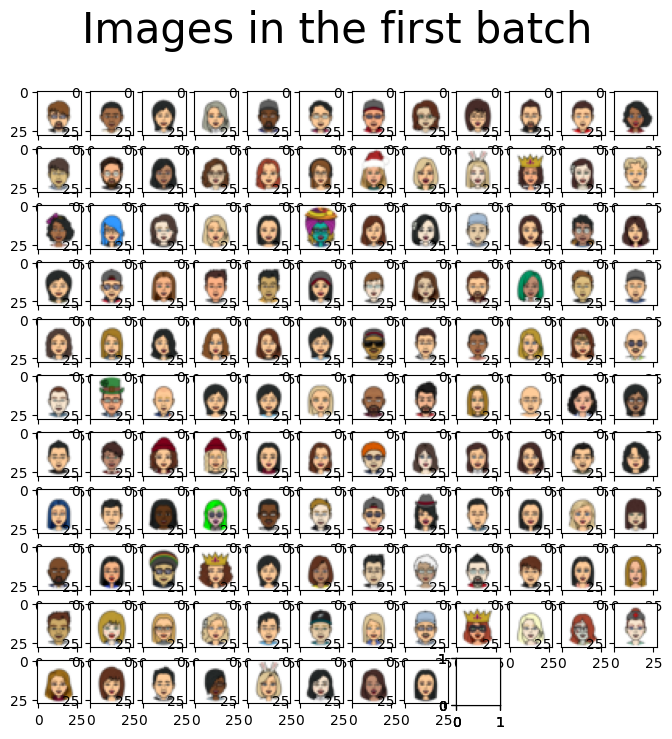

In [10]:
#show a batch of regular images
show_first_batch(dataloader)


In [11]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


# Section 5: Defining the main DDPM model, UNET for noise generation and the backward process, and positional embedding functions

In [12]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(3, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [ ]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu()
    im=np.array(images.permute(0,2,3,1))
    im = im / 2 + 0.5
    # print(images.shape)
        

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                
                # print(im.shape)
                # plt.imshow(images[idx][0], cmap="gray")
                plt.imshow(im[idx])
                
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [13]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [14]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=3, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

In [15]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [16]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [17]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((3, 28, 28), 3, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 3, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        # print(out.shape)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        # print(out.shape)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [18]:
# uu=MyUNet()
# x = torch.randn(16, 3, 28, 28).to(device)
# time_tensor = (torch.ones(16, 1) * 250).to(device).long()

# yy=uu(x,time_tensor)
# yy.shape

In [19]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [20]:
sum([p.numel() for p in ddpm.parameters()])

610350

# Section 6: show the diffusion (forward) process at t=0,2250,500,750,1000

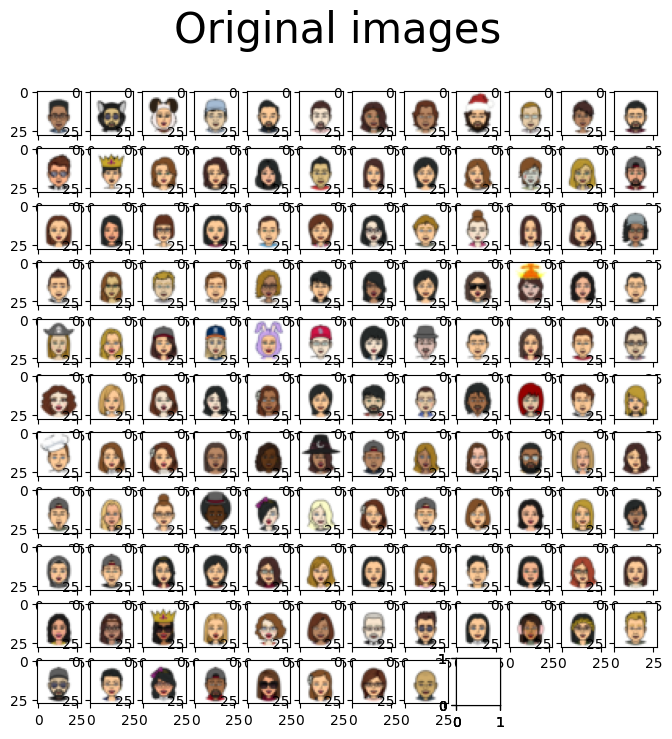

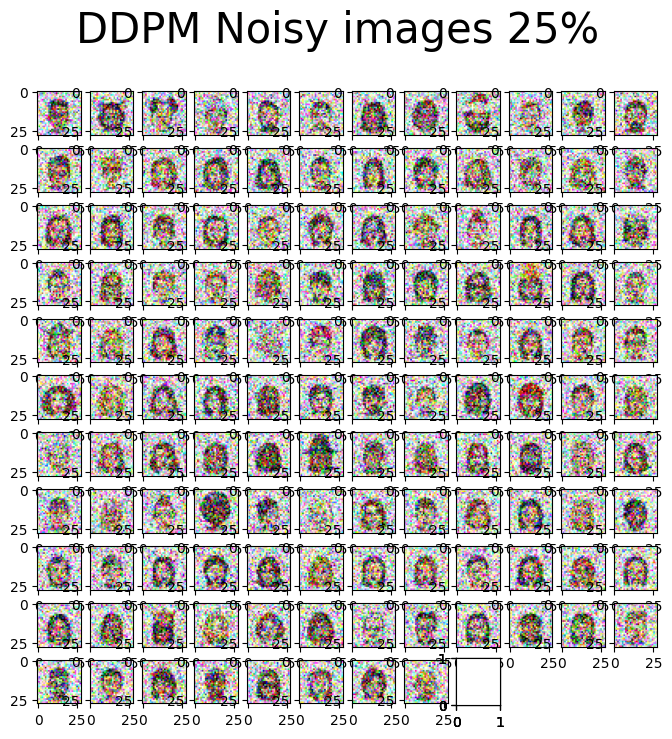

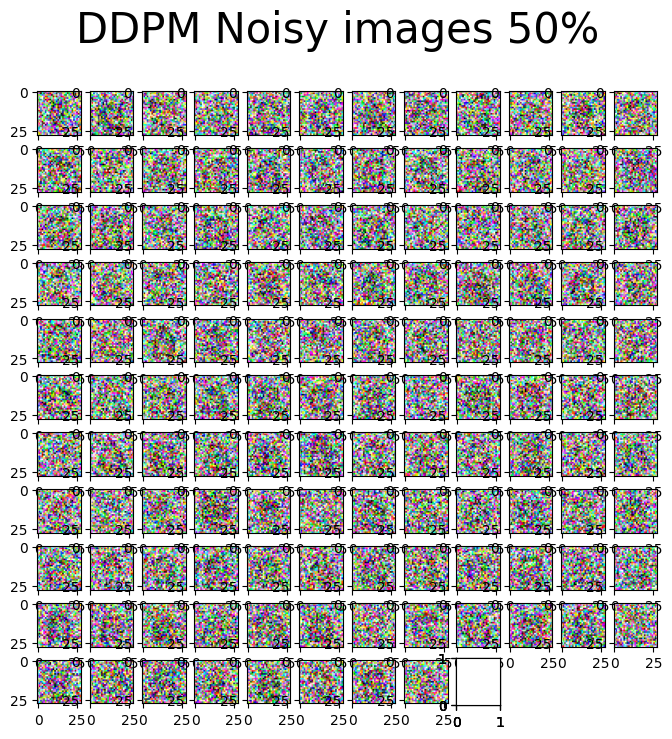

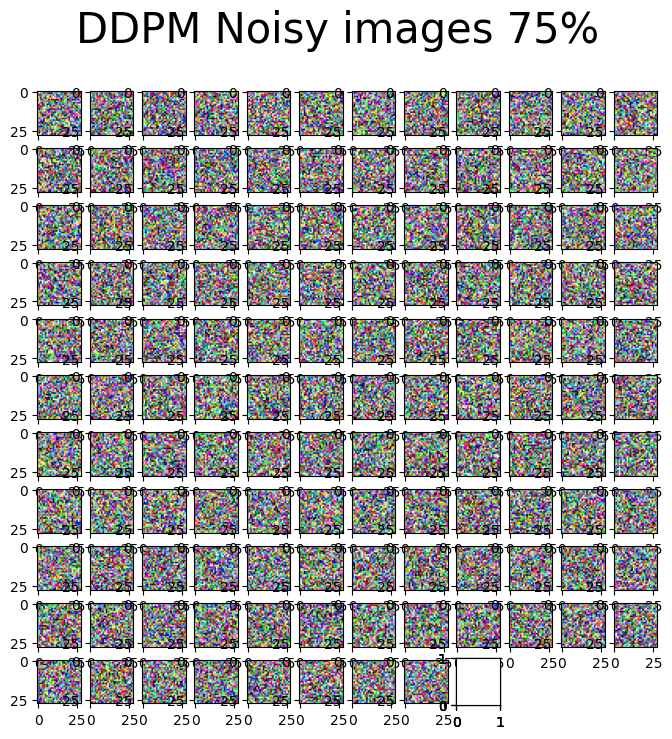

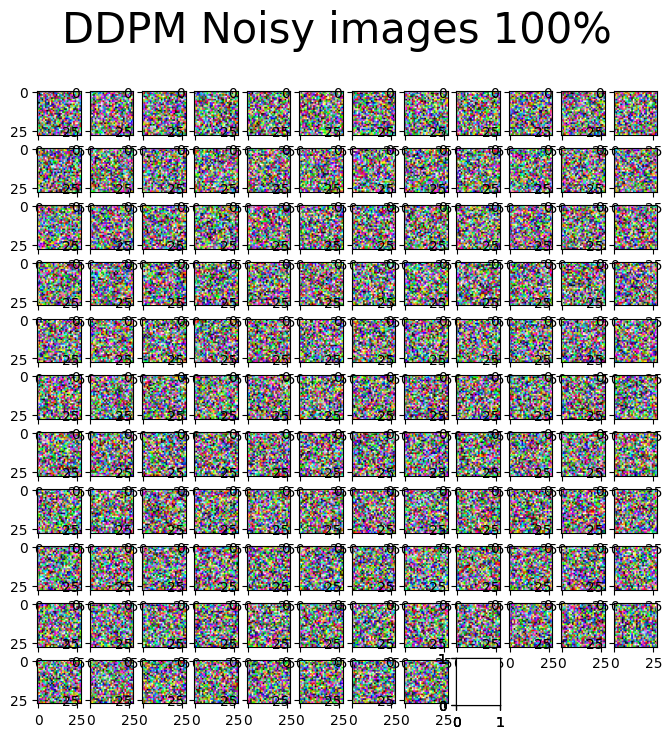

In [21]:

show_forward(ddpm, dataloader, device)

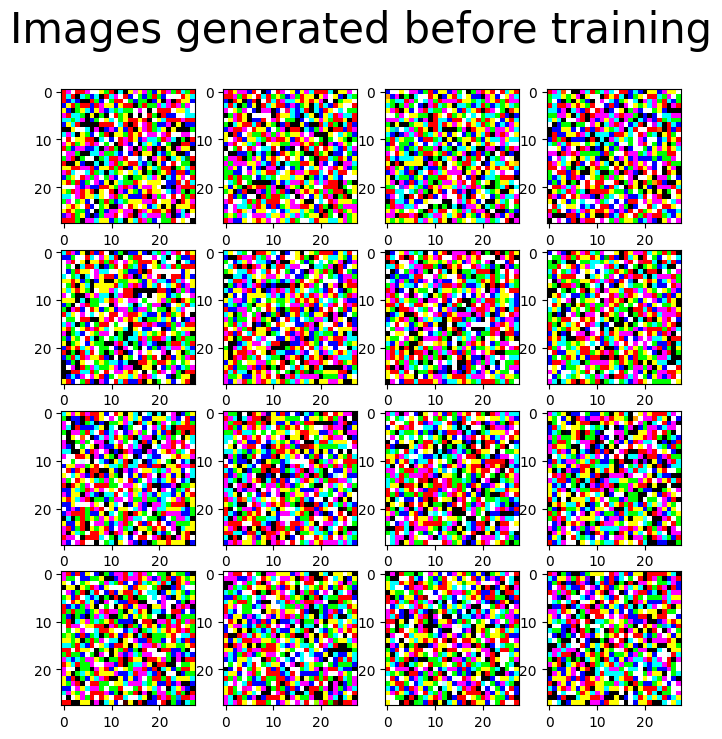

In [22]:
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

# Section 7: Training the DDPM model 

In [23]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            # print(eta_theta.shape,eta.shape)
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), 'ddpm_model_mnist_{}.pt'.format(str(epoch)))
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [24]:
# Training
# store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"
if not no_train:
    training_loop(ddpm, dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 1: 0.255 --> Best model ever (stored)


Epoch 2/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 2: 0.059 --> Best model ever (stored)


Epoch 3/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 3: 0.039 --> Best model ever (stored)


Epoch 4/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 4: 0.032 --> Best model ever (stored)


Epoch 5/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 5: 0.030 --> Best model ever (stored)


Epoch 6/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 6: 0.029 --> Best model ever (stored)


Epoch 7/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 7: 0.027 --> Best model ever (stored)


Epoch 8/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 8: 0.026 --> Best model ever (stored)


Epoch 9/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 9: 0.025 --> Best model ever (stored)


Epoch 10/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 10: 0.024 --> Best model ever (stored)


Epoch 11/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 11: 0.024 --> Best model ever (stored)


Epoch 12/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 12: 0.023 --> Best model ever (stored)


Epoch 13/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 13: 0.022 --> Best model ever (stored)


Epoch 14/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 14: 0.022 --> Best model ever (stored)


Epoch 15/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 15: 0.022


Epoch 16/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 16: 0.021 --> Best model ever (stored)


Epoch 17/17:   0%|          | 0/1010 [00:00<?, ?it/s]

Loss at epoch 17: 0.021 --> Best model ever (stored)


# Section 8: Inference 

In [27]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load('/content/ddpm_model_mnist_16.pt', map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


Generating new images


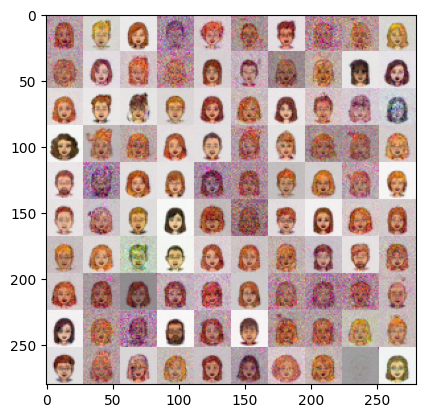

In [28]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="pls.gif" 
    )

normalized=generated.clone()
for i in range(len(normalized)):
    normalized[i] -= torch.min(normalized[i])
    normalized[i] *= 255 / torch.max(normalized[i])

# Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(100 ** 0.5))
frame = frame.cpu().numpy().astype(np.uint8)
plt.imshow(frame)



# Section 9: Conclusions
- The DDPM model was trained for 17 epochs only and encoraging results were seen
- Backward process (i.e)Inference for a batch: https://imgur.com/a/PVsLoeX